In [1]:
import functions as fnc
import numpy as np
import sys
import verde as vd
from choclo.point import gravity_u as pointgrav
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import mu_0
import harmonica as hm

Abstract:

Forward modelling of gravity and magnetics is essential for a wide variety of geophysical applications. Moreover, forward modelling of these fields for ellipsoidal bodies is essential to understand how geometry may effect the patterns in data aquired. This is especially applicable to real data as few targets will be mathematically spherical, and thus their field anomalies will be influenced by their geometry, particulalry for magentic measuremnts due to the depolarisation effect of the ellipsoidal shape. This project produced simple and effect ways of modelling the field produced by any number of ellipsoidal bodies, at any given depth, size/shape and orientation. The notebook provided is a brief walkthrough of the applications of the code; for full access to the code please see corresponding github repo.

# Forward modelling of ellipsoids:
## 1. Visualising the body

Forward modelling of ellipsoidal bodies initally requires defining the body by the semi axes, denoted here as 'a', 'b' and 'c'. The relationship between these values also defines the class of ellipsoid: a > b > c is a trixial ellipsoid, a > b = c is a prolate, and a < b = c is an oblate. 

In [2]:
# semiaxes lengths
a, b, c = (8, 6, 4) # triaxial ellipsoid

A second consideration is the rotation of the body within some defined coordinate system. We assume this 'global' coordinate system to be easting, northing and upward, with the spatial extent defined by the user.

In [3]:
# define coordinate grid (2D grid) at surface height
# extra_coords defines the surface height - here, this is 5 units above the origin height of the ellipsoid
coordinates = vd.grid_coordinates(region = (-20, 20, -20, 20), spacing = 0.5, extra_coords = 10)

 The local coordinate system is here defined as x, y, z, referring to the semiaxes of the ellipsoid, where the 'a' length corresponds with the x axis, which without rotations, corresponds to the Easting direction in the global coordinate system.
 
We define the angles of rotation of the ellipsoid using an intrinsic Euler matrix. Here, the local x axis correspond to roll, the y pitch, and the z yaw, such that rotations are given as:

$z - y' - x''$ 

Where the prime symbol represents the intrinsic nature of the rotation. By rotating about the z axis, this will impact the rotation about y... e.t.c.

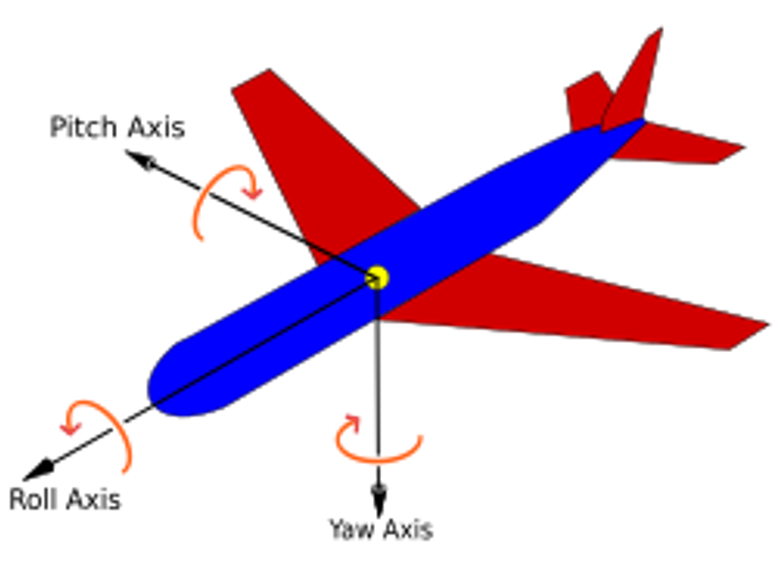

In [4]:

# origin of the ellipsoid in the coordinate system
centre = (0, 0, 0)

# create triaxial ellipsoids 
triaxial_example = fnc.TriaxialEllipsoid(a, b, c, yaw=0, pitch=0, roll=0, centre=centre)
triaxial_example2 = fnc.TriaxialEllipsoid(a, b, c, yaw=30, pitch=60, roll=0, centre=centre)

The interactive plot below visualises how these defined parameters effect the ellipsoid.

<IPython.core.display.Javascript object>


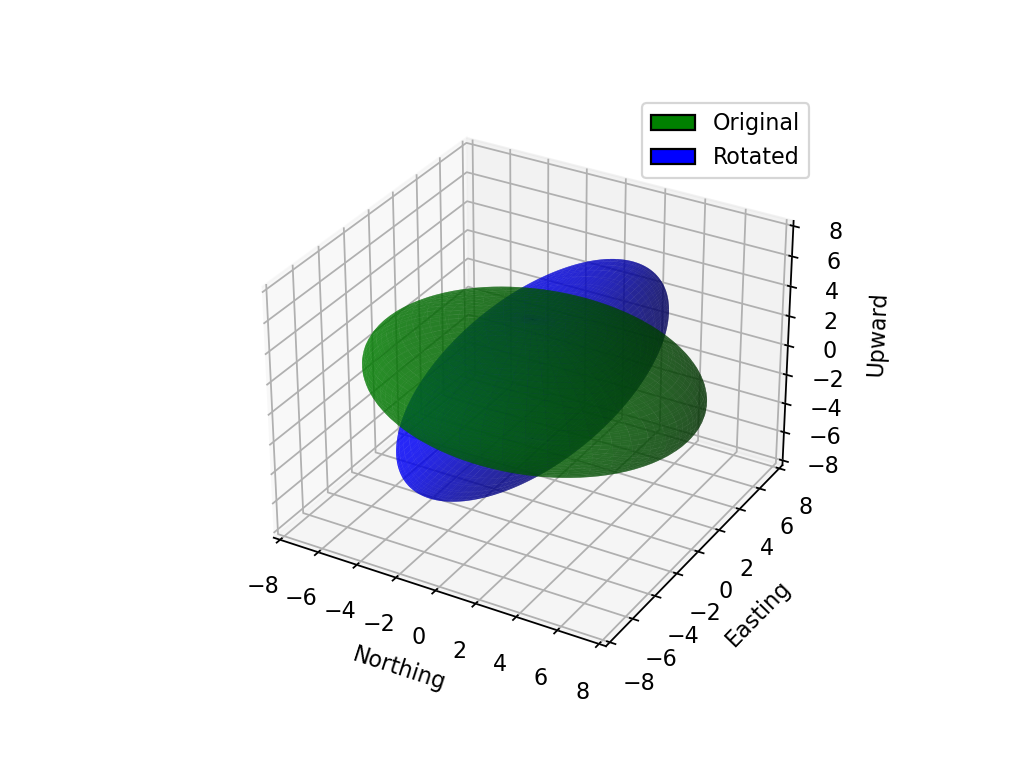

Text(0.5, 0, 'Upward')

In [5]:
%matplotlib notebook
yaw, pitch, roll = 30, 60, 0 # like triaxial_ellipsoid2
V = fnc._get_v_as_euler(yaw, pitch, roll) # Euler rotation matrix
x1, y1, z1 = fnc._generate_basic_ellipsoid(a, b, c) # creates ellipsoid surface
local_coords = fnc._global_to_local(x1, y1, z1, 0, V) # rotates ellipsoid surface

# plot interactive figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

max_radius = max(a, b, c)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius, max_radius))
    
ax.plot_surface(x1, y1, z1, color='green', alpha=0.6)
ax.plot_surface(local_coords[0], local_coords[1], local_coords[2], color='blue', alpha=0.6)

legend_elements = [
    Patch(facecolor='green', edgecolor='k', label='Original'),
    Patch(facecolor='blue', edgecolor='k', label='Rotated')
]
ax.legend(handles=legend_elements)

ax.set_xlabel('Northing')
ax.set_ylabel('Easting')
ax.set_zlabel('Upward')

## 2. Physical properties


Forward modelling of gravity requires deifning the density of the body, and magnetics requires the susceptabiity (k) - a single value if isotropic, or a tensor if anisotropic - and the regional field, $H_0$.

In [6]:
# regional field
b0 = np.array(hm.magnetic_angles_to_vec(55_000, 0.0, 90.0)) # in nT
H0 = np.array(b0 * 1e-9 / mu_0) # in Am

# susceptabiity examples
anisotropic_k = [((0.1, 0, 0), (0, 0.2, 0), (0, 0, 0.3))]
isotropic_k = 0.5

density = 2000

## 3. Gravity

Now we plot the gravitational field given the defined parameters.

In [7]:
# produce the easting, northing, upward components
ge, gn, gu = fnc.ellipsoid_gravity(coordinates, triaxial_example, density=2000)

<IPython.core.display.Javascript object>


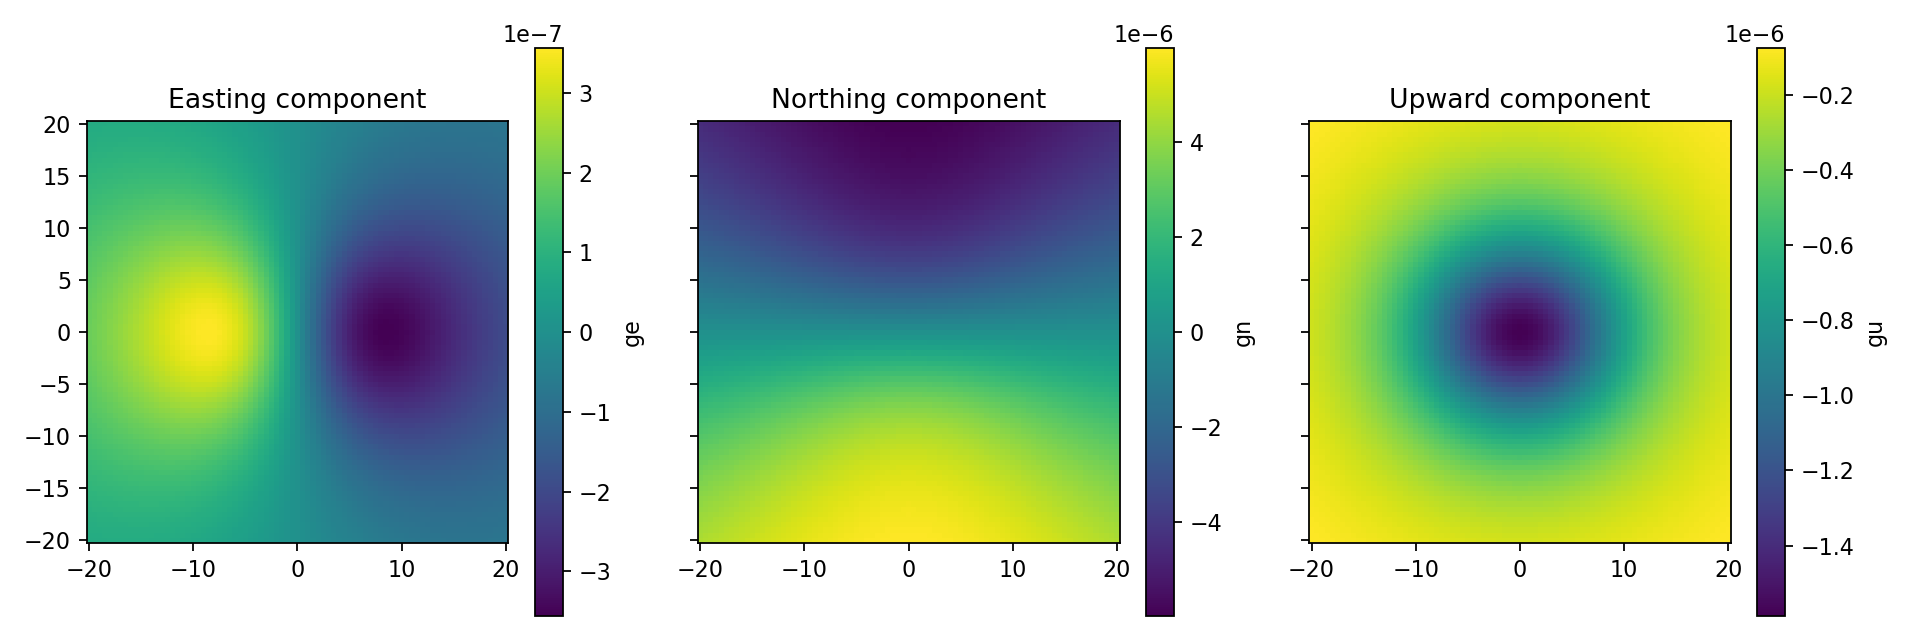

In [8]:
# plot each component
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, ge)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="ge")

tmp = ax2.pcolormesh(easting, northing, gn)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="gn")

tmp = ax3.pcolormesh(easting, northing, gu)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="gu")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

## 4. Magnetics

And the same for magentics:

In [9]:
# anisotropic example
be1, bn1, bu1 = fnc.ellipsoid_magnetics(coordinates, triaxial_example, anisotropic_k, H0)

In [10]:
# isotropic example
be2, bn2, bu2 = fnc.ellipsoid_magnetics(coordinates, triaxial_example, isotropic_k, H0)

Anisotropic body


<IPython.core.display.Javascript object>


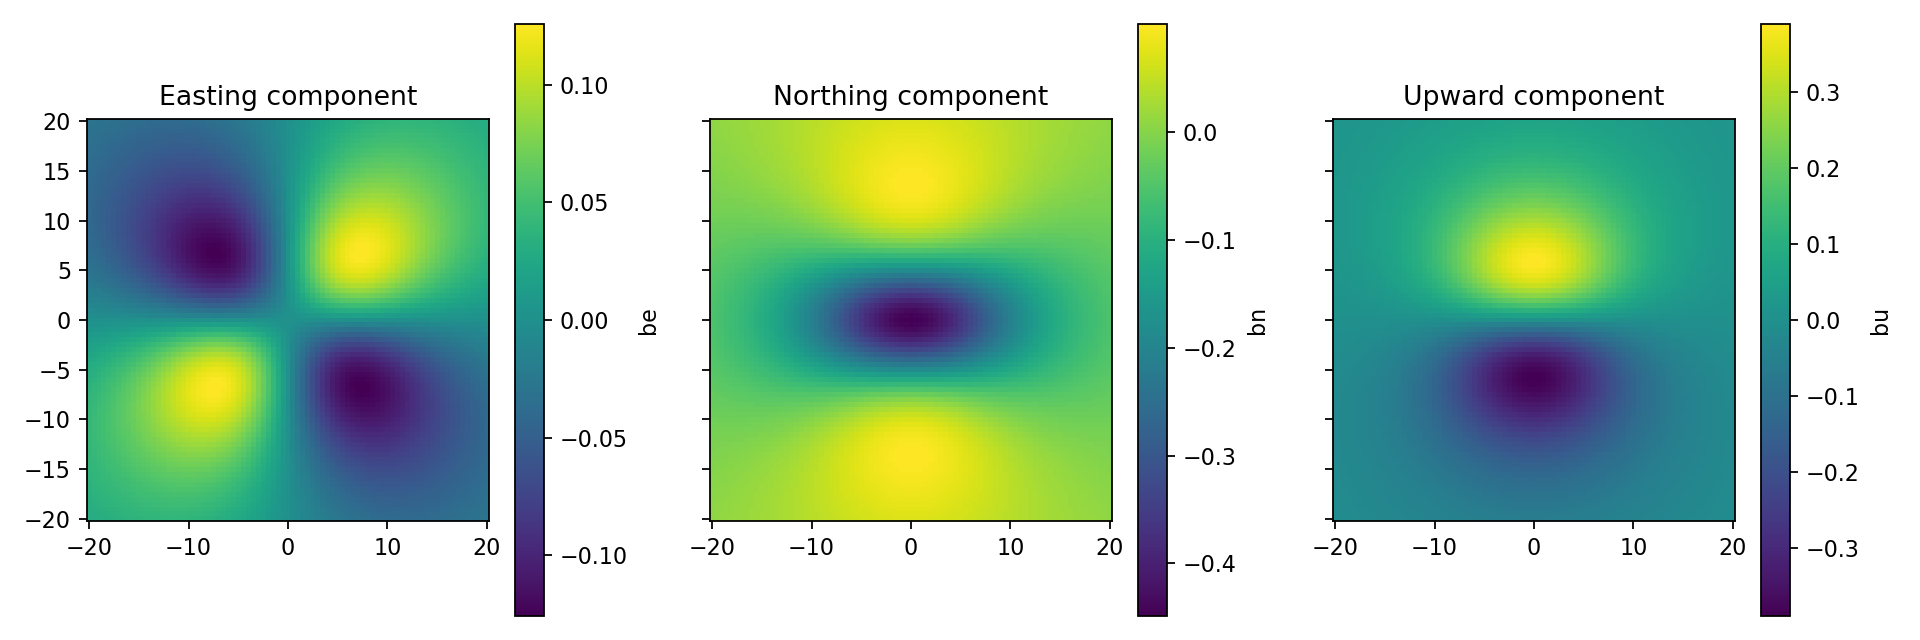

In [11]:
print("Anisotropic body")

easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, be1)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="be (nT)")

tmp = ax2.pcolormesh(easting, northing, bn1)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="bn (nT)")

tmp = ax3.pcolormesh(easting, northing, bu1)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="bu (nT)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

Isotropic body


<IPython.core.display.Javascript object>


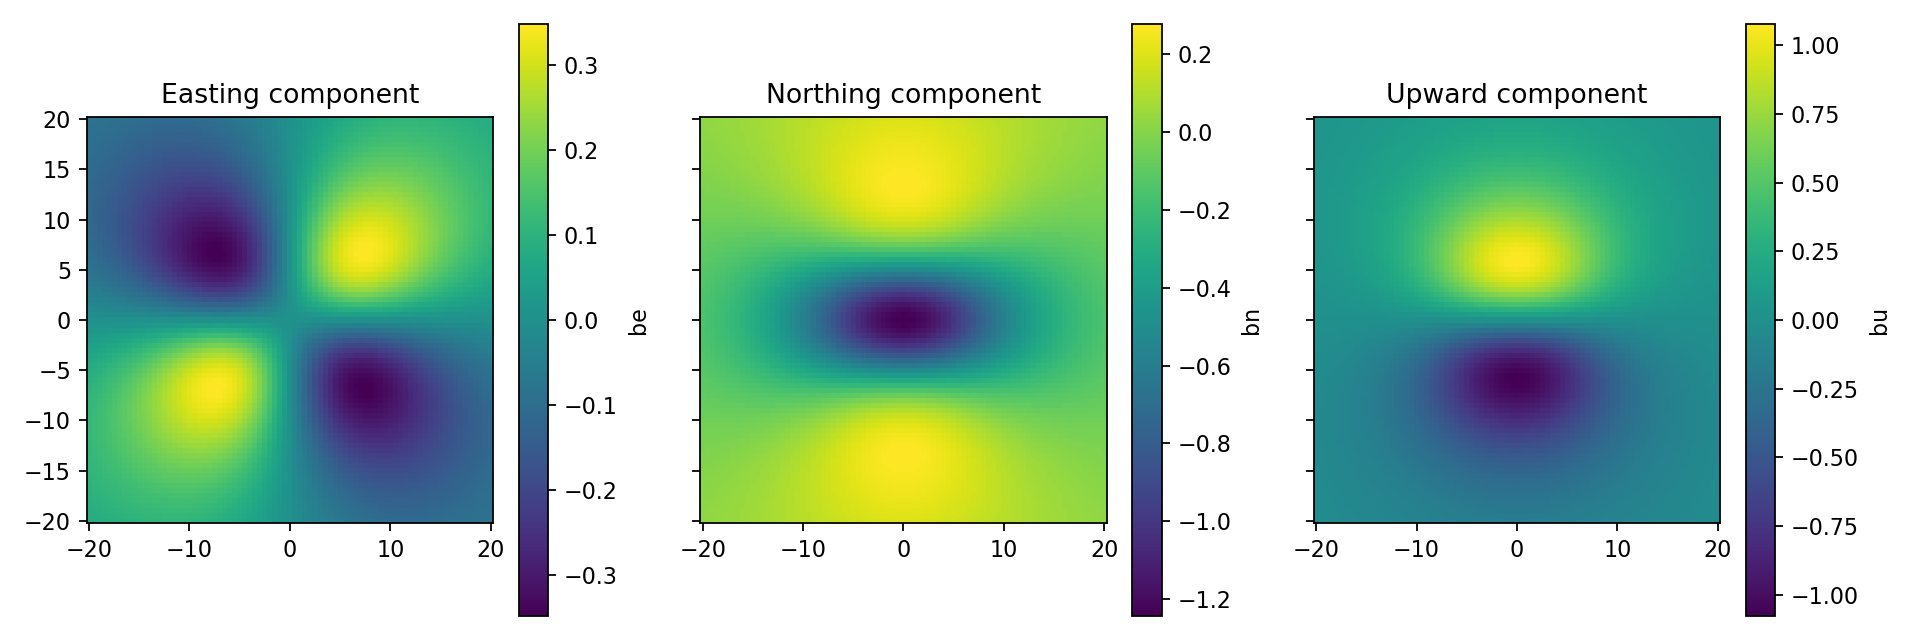

In [12]:
print("Isotropic body")

easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, be2)
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="be (nT)")

tmp = ax2.pcolormesh(easting, northing, bn2)
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="bn (nT)")

tmp = ax3.pcolormesh(easting, northing, bu2)
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="bu (nT)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

An interesting experiment as to how anisotropy changes the observed field:

Δbe for anisotropic vs isotropic


<IPython.core.display.Javascript object>


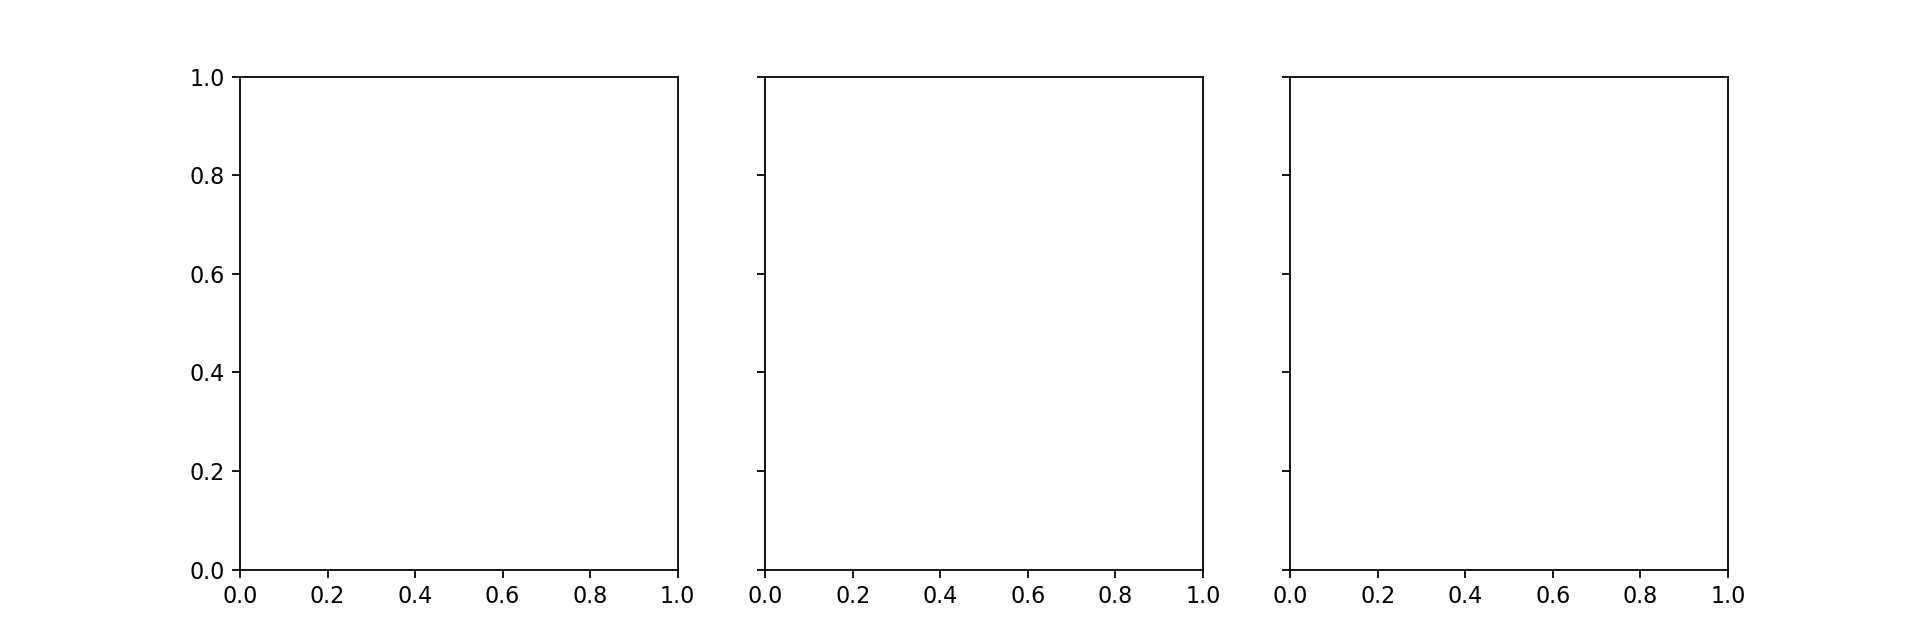

ValueError: not enough values to unpack (expected 2, got 1)

In [22]:
print("Δbe for anisotropic vs isotropic")
easting, northing = coordinates[:2]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))

tmp = ax1.pcolormesh(easting, northing, (be2 - be1))
ax1.set_title("Easting component")
plt.colorbar(tmp, ax=ax1, label="Δbe (nT)")

tmp = ax2.pcolormesh(easting, northing, (bn2 - bn1))
ax2.set_title("Northing component")
plt.colorbar(tmp, ax=ax2, label="Δbn (nT)")

tmp = ax3.pcolormesh(easting, northing, (bu2 - bu1))
ax3.set_title("Upward component")
plt.colorbar(tmp, ax=ax3, label="Δbu (nT)")

for ax in (ax1, ax2, ax3):
    ax.set_aspect("equal")

    
plt.tight_layout()
plt.show()

## 5. Near spheroid comparisons

Part of testing the code requires analysing how near-spheroid ellipsoids (e.g. a ⪆ b ⪆ c) behave compared to the same modelling of a sphere. 

### a) Comaprison to a point gravity approximation

In [14]:
# plot decay when moving along the z-axis
z = np.linspace(c, 10*c**2, 50)
x = y = np.zeros_like(z)

# lists to hold variables
gz = []
point_gz = []

# calculate ellipsoid mass
ellipsoid_mass =  density * 4/3 * np.pi * a * b * c


In [15]:
# only require upward component (or any singular component)
_, _, gu = fnc.ellipsoid_gravity((x, y, z), triaxial_example, density=density)

In [16]:
for i in range(len(x)):
        point_grav = pointgrav(x[i], y[i], z[i], 0, 0, 0, ellipsoid_mass)
        point_gz.append(point_grav)


<IPython.core.display.Javascript object>


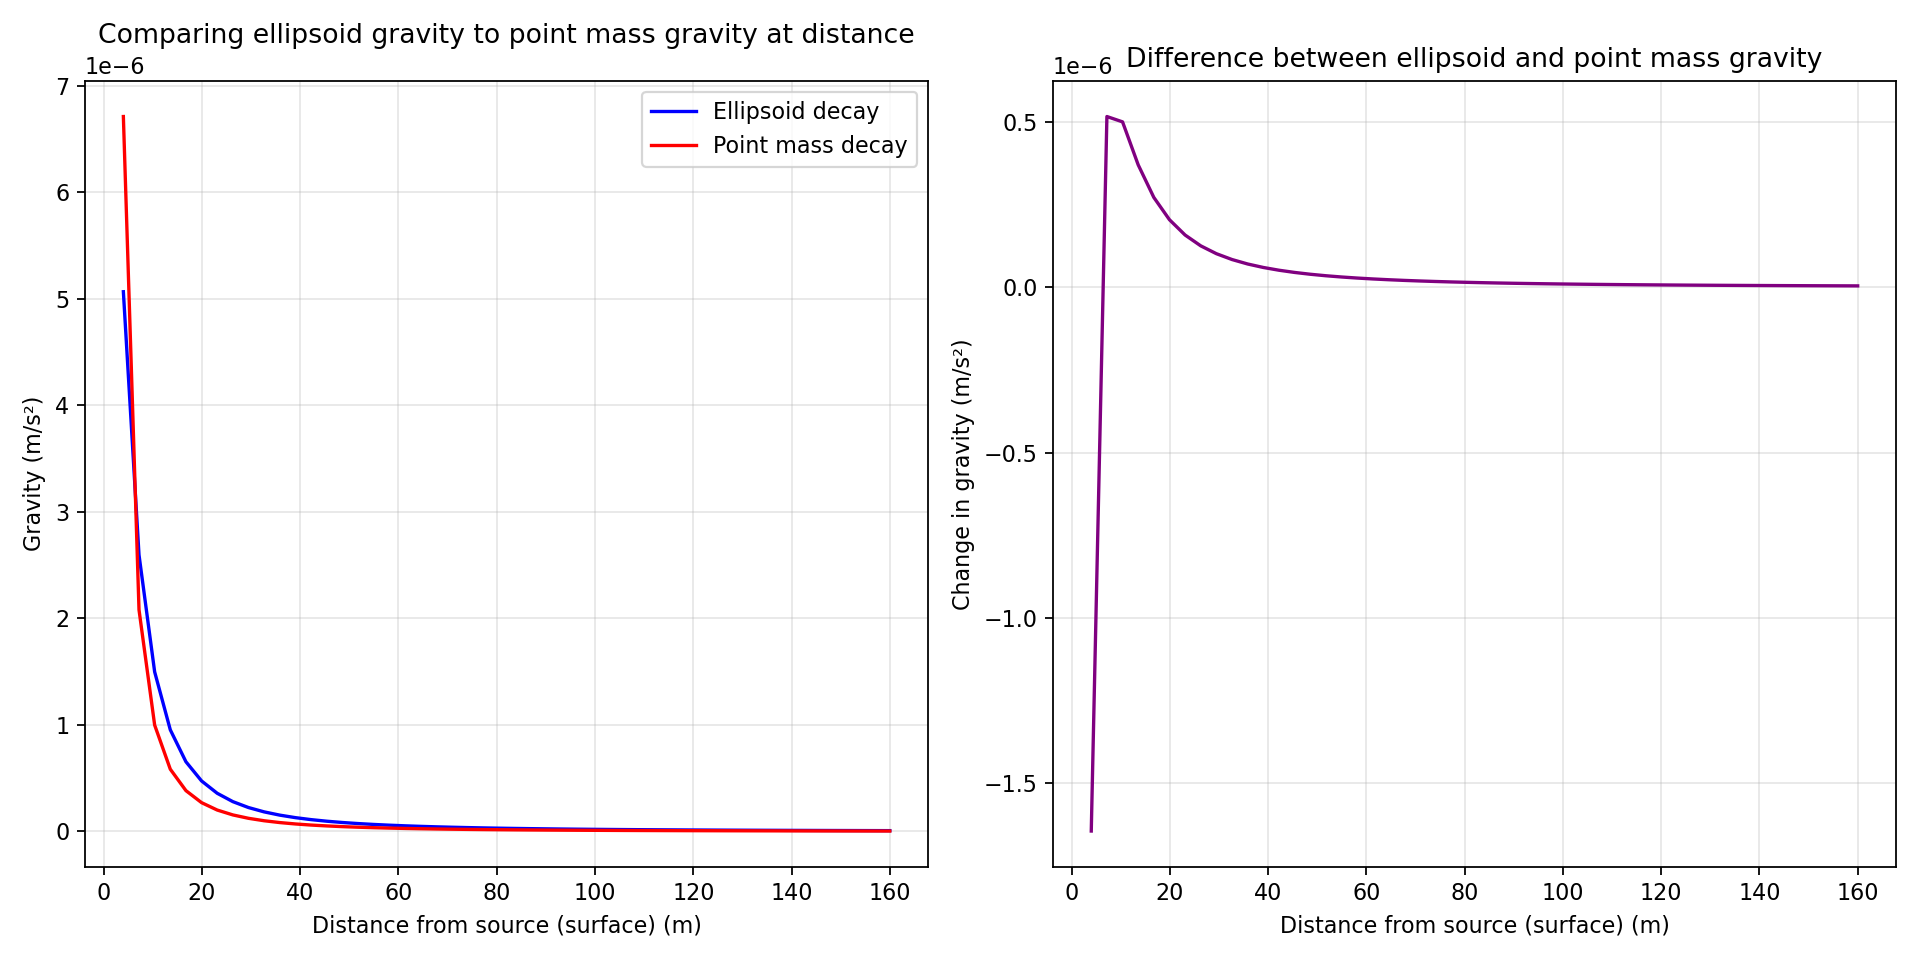

In [17]:
# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# plot 1: gravity decay of the two models
axs[0].set_title("Comparing ellipsoid gravity to point mass gravity at distance")
axs[0].plot(z, np.abs(gu), color='blue', label='Ellipsoid decay')
axs[0].plot(z, np.abs(point_gz), color='red', label='Point mass decay')
axs[0].set_ylabel('Gravity (m/s²)')
axs[0].set_xlabel('Distance from source (surface) (m)')
axs[0].legend()
axs[0].grid(alpha=0.3)

# plot 2: difference between the gravity models
axs[1].set_title("Difference between ellipsoid and point mass gravity")
axs[1].plot(z, np.abs(gu) - np.abs(point_gz), color='purple', label='Difference')
axs[1].set_xlabel('Distance from source (surface) (m)')
axs[1].set_ylabel('Change in gravity (m/s²)')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### b) Comparison to a dipole-modelled sphere approximation

<IPython.core.display.Javascript object>


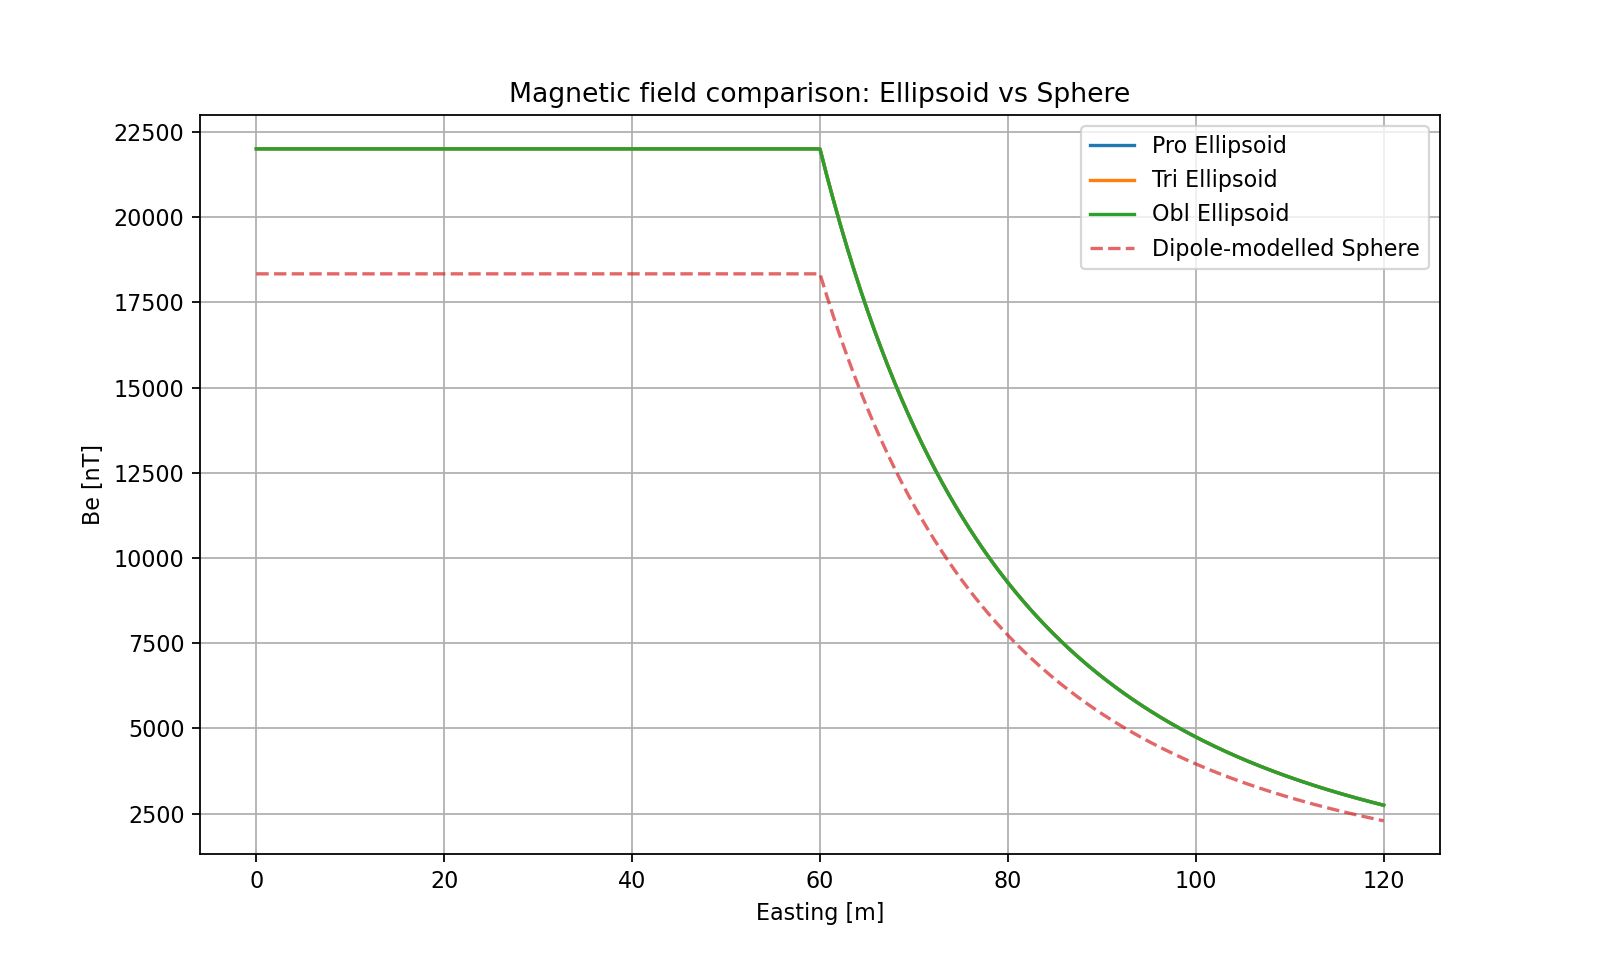

In [20]:
# Define magnetisation for the spheroid
M = isotropic_k * H0

# Define ellipsoid (make it nearly a sphere)
pro_ellipsoid = fnc.ProlateEllipsoid(a=60, b=59.99, yaw=0, pitch=0, centre=(0, 0, 0))
tri_ellipsoid = fnc.TriaxialEllipsoid(a=60, b=59.999, c=59.998, yaw = 0, pitch=0, roll=0, centre=(0, 0, 0))
obl_ellipsoid = fnc.OblateEllipsoid(a=59.99, b=60, yaw = 0, pitch=0, centre=(0, 0, 0))

# Define observation points along easting
easting = np.linspace(0, 2 * 60, 501)
northing, upward = np.zeros_like(easting), np.zeros_like(easting)
coordinates = tuple(np.atleast_2d(c) for c in (easting, northing, upward))

# Compute magnetic field for ellipsoid
be, bn, bu = fnc.ellipsoid_magnetics(coordinates, pro_ellipsoid, isotropic_k, (55_000, 0.0, 90.0), field="b")
be = be.ravel()

be1, bn1, bu1 = fnc.ellipsoid_magnetics(coordinates, tri_ellipsoid, isotropic_k, (55_000, 0.0, 90.0), field="b")
be1 = be1.ravel()
#
be2, bn2, bu2 = fnc.ellipsoid_magnetics(coordinates, obl_ellipsoid, isotropic_k, (55_000, 0.0, 90.0), field="b")
be2 = be2.ravel()

# Compute magnetic field for a sphere (analytic) 
b_e, b_n, b_u = fnc._sphere_magnetic(coordinates, radius=60, center=(0, 0, 0), magnetization= M)
b_e = b_e.ravel()

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(easting, be, label="Pro Ellipsoid")
plt.plot(easting, be1, label="Tri Ellipsoid")
plt.plot(easting, be2, label="Obl Ellipsoid")

plt.plot(easting, b_e, '--', label="Dipole-modelled Sphere", alpha=0.7)
plt.xlabel("Easting [m]")
plt.ylabel("Be [nT]")
plt.legend()
plt.title("Magnetic field comparison: Ellipsoid vs Sphere")
plt.grid(True)
plt.show()


We can see here that they do not match... but this is actually expected for ellipsoids when the susceptability exceeds are k = 0.1. This is due to the strong demagntisation effect due to the geometry. For lower susceptibilties:

<IPython.core.display.Javascript object>


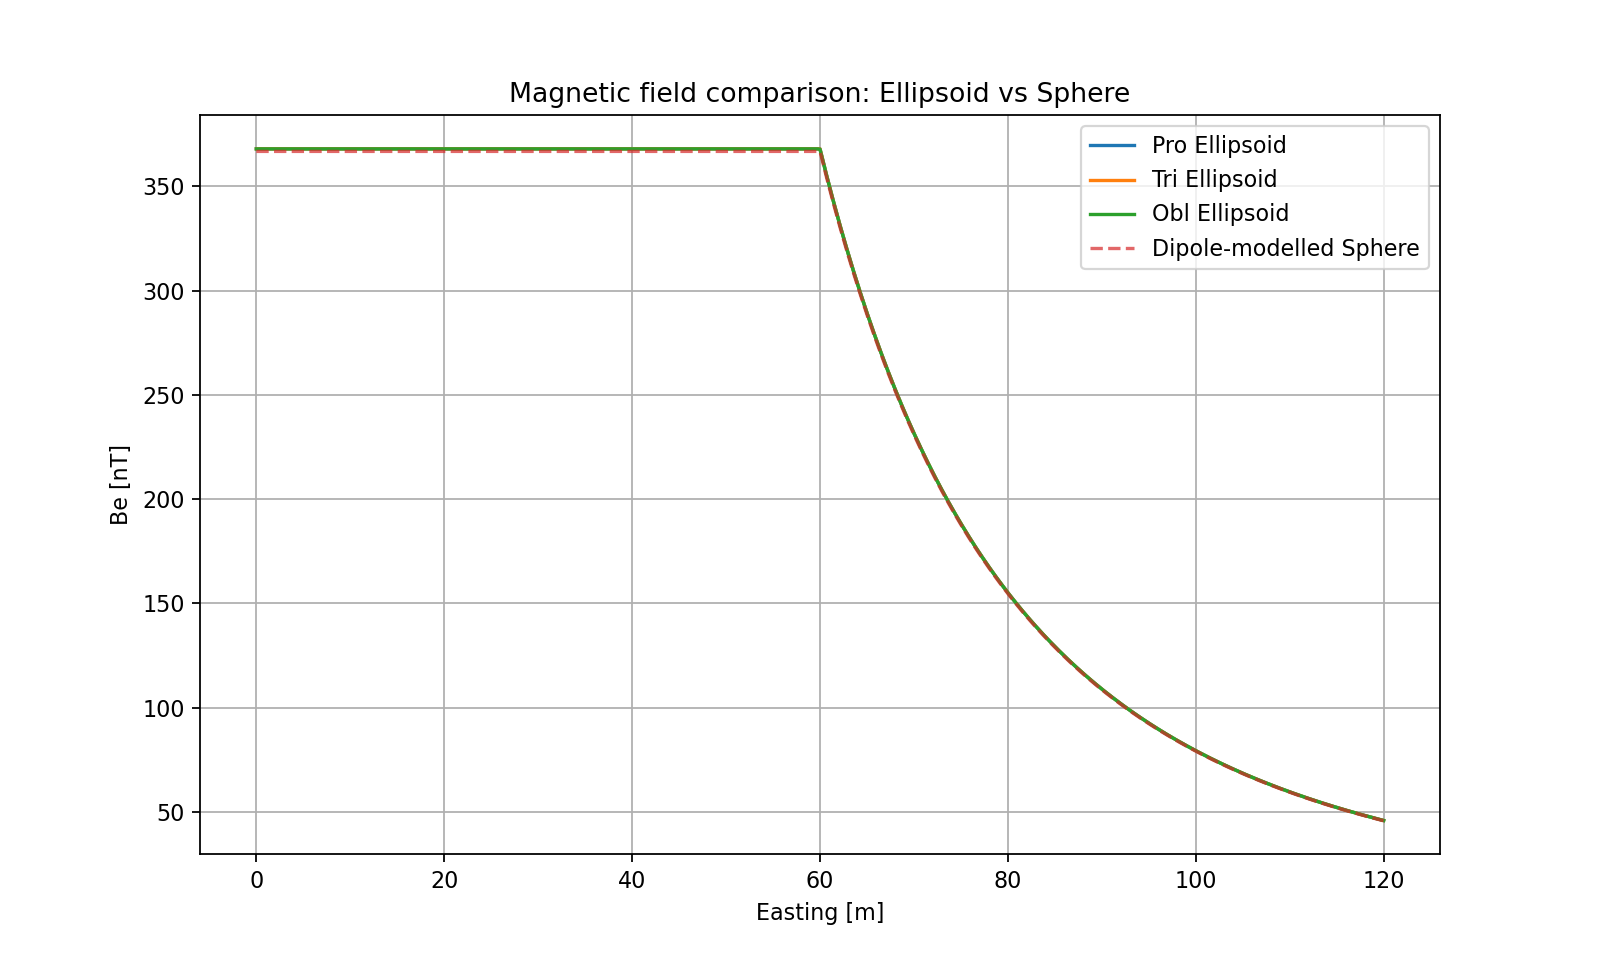

In [21]:
k = 0.01 # a lower susceptability value)

M = k * H0

# Define ellipsoid (make it nearly a sphere)
pro_ellipsoid = fnc.ProlateEllipsoid(a=60, b=59.99, yaw=0, pitch=0, centre=(0, 0, 0))
tri_ellipsoid = fnc.TriaxialEllipsoid(a=60, b=59.999, c=59.998, yaw = 0, pitch=0, roll=0, centre=(0, 0, 0))
obl_ellipsoid = fnc.OblateEllipsoid(a=59.99, b=60, yaw = 0, pitch=0, centre=(0, 0, 0))

# Define observation points along easting
easting = np.linspace(0, 2 * 60, 501)
northing, upward = np.zeros_like(easting), np.zeros_like(easting)
coordinates = tuple(np.atleast_2d(c) for c in (easting, northing, upward))

# Compute magnetic field for ellipsoid
be, bn, bu = fnc.ellipsoid_magnetics(coordinates, pro_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be = be.ravel()

be1, bn1, bu1 = fnc.ellipsoid_magnetics(coordinates, tri_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be1 = be1.ravel()
#
be2, bn2, bu2 = fnc.ellipsoid_magnetics(coordinates, obl_ellipsoid, k, (55_000, 0.0, 90.0), field="b")
be2 = be2.ravel()

# Compute magnetic field for a sphere (analytic) 
b_e, b_n, b_u = fnc._sphere_magnetic(coordinates, radius=60, center=(0, 0, 0), magnetization= M)
b_e = b_e.ravel()

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(easting, be, label="Pro Ellipsoid")
plt.plot(easting, be1, label="Tri Ellipsoid")
plt.plot(easting, be2, label="Obl Ellipsoid")

plt.plot(easting, b_e, '--', label="Dipole-modelled Sphere", alpha=0.7)
plt.xlabel("Easting [m]")
plt.ylabel("Be [nT]")
plt.legend()
plt.title("Magnetic field comparison: Ellipsoid vs Sphere")
plt.grid(True)
plt.show()

It matches perfectly.